## Project Overview

In this experiment, we investigate how randomly generated variables, when convolved with a moving‐average filter to introduce autocorrelation, can nonetheless be predicted remarkably well by a regression regressor. The main objectives are:

1. **Generate six random signals** (x1–x5 as features and y as the target) of length 1000, each with a controllable level of autocorrelation.
2. **Train an XGBoost regressor** to predict y from x1–x5.
3. **Observe how the strength of autocorrelation** (controlled by the “correlation window” in a moving average) affects regressor performance.
4. **Demonstrate the danger of spurious correlation**: even though all inputs are intrinsically random, the regressor’s predictive accuracy increases dramatically when autocorrelation is higher.
5. **Raise awareness** that hidden autocorrelation in real‐world features can lead to deceptively high performance.

---

## ACF and PACF

- **Autocorrelation Function (ACF):**  
  - Shows the correlation of the signal with its own past values at different lags.  
  - ACF at lag _k_ measures how well the series at time _t_ correlates with the series at time _t–k_.  

- **Partial Autocorrelation Function (PACF):**  
  - Shows the correlation between the signal and its lagged values **after removing** the effects of all shorter lags.  
  - PACF at lag _k_ measures the correlation between $x_t$ and $x_{t-k}$ after accounting for intermediate lags (1,…, _k–1_).  
  
- **Key Difference:**  
  - **ACF** includes both direct and indirect correlations (e.g., correlation at lag 3 might be driven by lag 1 and lag 2).  
  - **PACF** isolates only the direct correlation at each lag by removing indirect effects from intermediate lags.

---

## Methodology

1. **Signal Generation**  
   - For each signal, generate pure Gaussian noise:  
     ```python
     noise = np.random.normal(0, 1, length)
     ```  
   - Create a moving‐average window of size _w_:  
     ```python
     window = np.ones(w) / w
     ```  
   - Convolve the noise with this window (using `mode='same'`) to produce a signal with autocorrelation:  
     ```python
     signal = np.convolve(noise, window, mode='same')
     ```  
   - Repeat this process six times (five features and one target) for each choice of _w_.

2. **Varying Autocorrelation Strength**  
   - The parameter `correlation_window = w` determines how “smooth” (autocorrelated) each signal is.  
   - Lower _w_ (e.g., _w_ = 10) creates mild autocorrelation; higher _w_ (e.g., _w_ = 50) produces strong autocorrelation.

3. **Train/Test Split**  
   - Stack the six signals into a single DataFrame of shape (1,000 samples × 6 columns).  
   - Perform a random 75/25 train/test split.  
   - Features: columns `x1, x2, x3, x4, x5`  
   - Target: column `y`

4. **regressoring with XGBoost**  
   - Initialize an `XGBRegressor` with four hyperparameters.  
   - Fit on the training set.  
   - Predict on the test set and compute these metrics:  
     - **MSE** (Mean Squared Error)  
     - **RMSE** (Root Mean Squared Error)  
     - **MAE** (Mean Absolute Error)  
     - **$R^2$** (Coefficient of Determination)

5. **Comparison Across Windows**  
   - Repeat steps 1–4 for different window sizes (e.g., 1 and 50) to quantify how regressor performance changes as autocorrelation increases.

---

## Results

Below is a summary table showing how the regressor’s performance on the test set changes when the correlation window is increased from 1 to 50:

| Correlation Window |   MSE   |  RMSE   |  MAE   |   R²    |
|--------------------|---------|---------|--------|---------|
| **1**              | 1.2761  | 1.1296  | 0.8667 | -0.218  |
| **50**             | 0.0075  | 0.0864  | 0.0629 | 0.6544  |

- **Window = 1 (mild autocorrelation)**  
  - MSE ≈ 1.2761
  - RMSE ≈ 1.1296 
  - MAE ≈ 0.8667 
  - $R^2$ ≈ -0.218 (negative $R^2$ indicates performance worse than predicting the mean)

- **Window = 50 (strong autocorrelation)**  
  - MSE ≈ 0.0075
  - RMSE ≈ 0.0864
  - MAE ≈ 0.0629
  - $R^2$ ≈ 0.6544 (about 70% of variance explained)

---

## Interpretation of Metrics

- **MSE (Mean Squared Error)**:  
  - Measures the average of the squared differences between predictions and true values. Lower is better; perfect regressor → 0.  
  - When autocorrelation is low (w = 1), MSE is relatively large (1.2761). When autocorrelation is high (w = 50), MSE is much smaller (0.0075).

- **RMSE (Root Mean Squared Error)**:  
  - Square root of MSE, expressed in the same units as y. Lower is better.  
  - w = 1 → 1.1296  
  - w = 50 → 0.0864

- **MAE (Mean Absolute Error)**:  
  - Average absolute deviation between predictions and true values. More robust to outliers. Lower is better.  
  - w = 1 → 0.8667  
  - w = 50 → 0.0629

- **$R^2$ (Coefficient of Determination)**:  
  - Fraction of variance in y explained by the regressor.  
  - w = 1 → -0.218 (regressor is worse than always predicting the mean)  
  - w = 50 → 0.6544 (regressor explains ~70% of variance)

---

## Key Takeaways

1. **Spurious Predictability**  
   - Even though all features and the target began as independent random noise, applying a moving average filter introduces hidden autocorrelation.  
   - XGBoost learns this autocorrelation structure, resulting in surprisingly high predictive accuracy when autocorrelation is strong.

2. **Real‑World Danger**  
   - In practice, features may have unintended autocorrelation (e.g., time‑series data with trend or seasonality).  
   - Training a regressor without checking for autocorrelation can produce deceptively good results that do not generalize.

3. **Recommendation**  
   - **Always check for autocorrelation** (and other hidden structures) in your features before regressor training.  
   - If features share autocorrelation with the target, remove or regressor that structure explicitly to avoid overoptimistic performance.

---

## Conclusion

- We generated random signals and introduced autocorrelation using a moving average.  
- We observed that, as the correlation window increased, XGBoost performance improved dramatically, even though no true causal relationship existed.  
- This exercise highlights the importance of diagnosing autocorrelation (and other hidden dependencies) in real datasets to ensure regressors are genuinely learning meaningful patterns.  

In [ ]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
import xgboost as xgb
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    KFold,
    cross_val_score,
    TimeSeriesSplit,
)
from matplotlib.patches import Patch
import plotly.graph_objects as go

# Data Creation

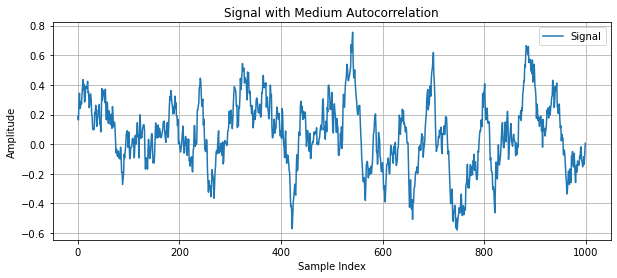

In [41]:
def generate_signal(length=1000, correlation_window=10):
    """
    Generates a signal with medium autocorrelation.

    Parameters:
        length (int): Length of the signal.
        correlation_window (int): Size of the window for the moving average to control correlation strength.

    Returns:
        np.ndarray: Signal with medium autocorrelation.
        
    *Note*: the "correlation_window" must be less than the "length"
    """
    # Generate random noise
    noise = np.random.normal(0, 1, length)
   
    # Create a moving average filter
    window = np.ones(correlation_window) / correlation_window
   
    # Apply the moving average filter to introduce correlation
    signal = np.convolve(noise, window, mode='same')
   
    return signal

# Generate the signal
signal = generate_signal(length=1000, correlation_window=20)
noise = np.random.normal(0, 1, 1000)

# Plot the signal
plt.figure(figsize=(10, 4))
# plt.plot(np.random.normal(0, 1, 1000))
plt.plot(signal, label="Signal")
plt.title("Signal with Medium Autocorrelation")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

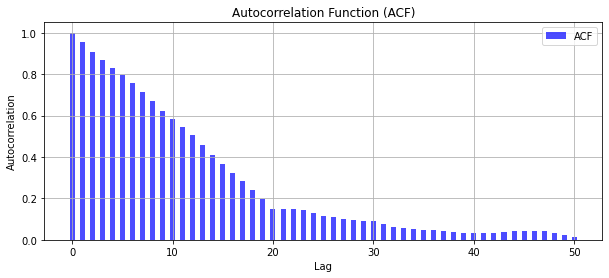

In [42]:
# Calculate the ACF of the signal
lags = 50  # Number of lags to compute
autocorr_values = acf(signal, nlags=lags, fft=True)

# Plot the ACF
plt.figure(figsize=(10, 4))
plt.bar(range(lags + 1), autocorr_values, width=0.5, color='blue', alpha=0.7, label="ACF")
plt.title("Autocorrelation Function (ACF)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid()
plt.legend()
plt.show()

# Display the ACF values for the first few lags
# autocorr_values[:10]  # Show ACF values for lags 0 through 9

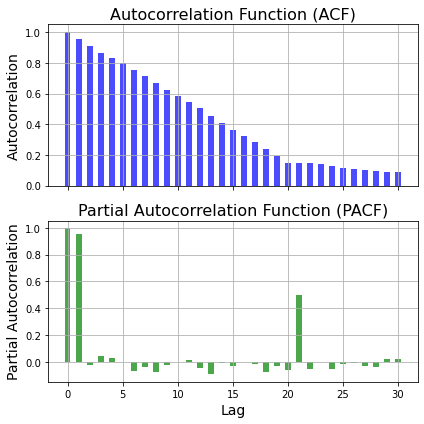

In [43]:
# Number of lags
lags = 30

# Compute ACF and PACF
acf_values = acf(signal, nlags=lags, fft=True)
pacf_values = pacf(signal, nlags=lags, method='ywm')

fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

# ACF plot
axes[0].bar(range(lags + 1), acf_values, width=.5, color='blue', alpha=0.7)
axes[0].set_title("Autocorrelation Function (ACF)", fontsize=16)
axes[0].set_ylabel("Autocorrelation", fontsize=14)
axes[0].grid(True)

# PACF plot
axes[1].bar(range(lags + 1), pacf_values, width=0.5, color='green', alpha=0.7)
axes[1].set_title("Partial Autocorrelation Function (PACF)", fontsize=16)
axes[1].set_xlabel("Lag", fontsize=14)
axes[1].set_ylabel("Partial Autocorrelation", fontsize=14)
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Six Features and One Target

In [7]:
# Set a fixed seed for reproducibility
np.random.seed(42)

# Number of variables and samples
num_var = 6
num_samples = 1000
correlation_window = 10

# Generate 6 variables with the length of 1000 with medium autocorrelation
variables = [generate_signal(num_samples, correlation_window) for _ in range(num_var)]

# Create a dataframe where each variable is a column
df = pd.DataFrame(np.column_stack(variables), columns=[f'x{i}' for i in range(1,6)] + ['y'])

# Add an 'index' column at the front, where the values are the index of the data
df.insert(0, 'index', df.index)

df.head()

,index,x1,x2,x3,x4,x5,y
0,0,0.229501,0.243491,-0.381369,-0.073756,-0.177091,-0.227008
1,1,0.206088,0.282839,-0.360040,-0.207304,-0.117834,-0.354431
2,2,0.364009,0.372358,-0.359919,-0.158700,-0.388273,-0.249583
3,3,0.440753,0.435876,-0.441628,-0.313431,-0.451262,-0.200805
4,4,0.393805,0.540831,-0.375704,-0.205162,-0.500089,-0.274229


In [8]:
# help(xgb.XGBRegressor)

In [9]:
np.random.seed(42)
# Data and Target
data = df.drop(['y'], axis=1) # x1,...,x5
target = df['y']
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=.25)


# regressor Training

In [10]:
regressor = xgb.XGBRegressor(eval_metric='rmsle')

# Search for the optimal hyperparamers
param_grid = {'max_depth': [4,5,6,7],
              'n_estimators': [100,500,600,700],
              'learning_rate': [0.01,0.015,0.3]}

# Try every combination o fthe above values
search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train)

print('The best hyperparameters are ', search.best_params_)

The best hyperparameters are  {'learning_rate': 0.015, 'max_depth': 6, 'n_estimators': 700}


In [11]:
# Create regressor instance
regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmsle')

regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.015, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=700, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

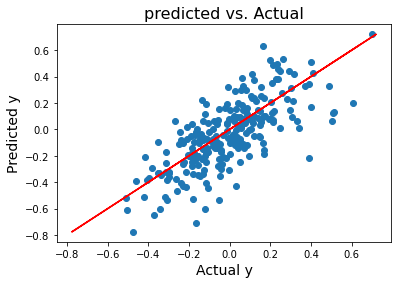

In [12]:
# Use the regressor to predict
predict = regressor.predict(X_test)

# Scatter plot of actual vs. predicted
plt.plot(y_test, y_test, color='red')
plt.scatter(predict, y_test)
plt.xlabel('Actual y', fontsize=14)
plt.ylabel('Predicted y', fontsize=14)
plt.title('predicted vs. Actual', fontsize=16)
plt.show()

In [13]:
# Mean Squared Error
mse = mean_squared_error(y_test, predict)

# Root Mean Squared Error
rmse = np.sqrt(mse)

# Mean Absolute Error
mae = mean_absolute_error(y_test, predict)

# R-squared
r2 = r2_score(y_test, predict)

print(f"Test MSE : {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")
print(f"Test R\u00B2  : {r2:.4f}")

Test MSE : 0.0316
Test RMSE: 0.1777
Test MAE : 0.1366
Test R²  : 0.5222


# Different Windows

In [14]:
def evaluate_for_windows(windows, num_samples=1000, test_size=.25):
    """
    Fro each correlation window in 'windows', generate data, train an XGBRegressor,
    and compute regression metrics.
    
    Parameters:
        windows (list of int): List of correlation window sizes to evaluate.
        num_samples (int): Number of samples per variable (default: 1000).
        test_size (float): Proportion of data to reserve for testing (default: 0.25).
    
    Returns:
        pd.DataFrame: A DataFrame summarizing MSE, RMSE, MAE, and R2 for each window.
    """
    result = []
    
    for window in windows:
        # Generate six signals (x1-x5 as features, y as target)
        signals = [generate_signal(length=num_samples, correlation_window=window) for _ in range(6)]
        df = pd.DataFrame(
            np.column_stack(signals),
            columns=[f'x{i}' for i in range(1,6)] + ['y']
        )
        
        # Split into train and test
        train_df, test_df = train_test_split(df, test_size=test_size, random_state=42, shuffle=True)
        X_train, y_train = train_df[['x1', 'x2', 'x3', 'x4', 'x5']], train_df['y']
        X_test, y_test = test_df[['x1', 'x2', 'x3', 'x4', 'x5']], test_df['y']
        
        # train XGBRegressor
        regressor = xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmsle')

        regressor.fit(X_train, y_train)
        
        # Predict and compute metrics
        y_pred = regressor.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        result.append({
            'correlation_window': window,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R\u00B2': r2
        })
        
    return pd.DataFrame(result)

In [15]:
windows_to_test = [1,5,10,50,100]
metrics_df = evaluate_for_windows(windows_to_test)

metrics_df

,correlation_window,MSE,RMSE,MAE,R²
0,1,1.399251,1.182899,0.926300,-0.180573
1,5,0.218433,0.467368,0.369630,-0.041366
2,10,0.064759,0.254478,0.202397,0.099760
3,50,0.005140,0.071692,0.053634,0.715451
4,100,0.001302,0.036086,0.024375,0.803508


# Cross Validation

Cross-validation is a robust resampling technique for estimating how well a predictive model will generalize to unseen data. In its most common form (k-fold cross-validation), the dataset is split into k equally-sized “folds” the model is trained k times, each time using k − 1 folds for training and the remaining fold for validation, and the prediction scores are averaged across all k runs. This process reduces the variance associated with any single train/test split, guards against overfitting, and provides a more reliable assessment of model performance and stability.

## Time Series

In [ ]:
def plot_cross_val(n_splits: int,
                   splitter_func,
                   df: pd.DataFrame,
                   title_text: str) -> None:
  
    """Function to plot the cross validation of various
    sklearn splitter objects."""

    split = 1
    plot_data = []

    for train_index, valid_index in splitter_func(n_splits=n_splits).split(df):
        plot_data.append([train_index, 'Train', f'{split}'])
        plot_data.append([valid_index, 'Test', f'{split}'])
        split += 1

    plot_df = pd.DataFrame(plot_data,
                           columns=['Index', 'Dataset', 'Split'])\
                           .explode('Index')

    fig = go.Figure()
    for _, group in plot_df.groupby('Split'):
        fig.add_trace(go.Scatter(x=group['Index'].loc[group['Dataset'] == 'Train'],
                                 y=group['Split'].loc[group['Dataset'] == 'Train'],
                                 name='Train',
                                 line=dict(color="blue", width=10)
                                 ))
        fig.add_trace(go.Scatter(x=group['Index'].loc[group['Dataset'] == 'Test'],
                                 y=group['Split'].loc[group['Dataset'] == 'Test'],
                                 name='Test',
                                 line=dict(color="goldenrod", width=10)
                                 ))

    fig.update_layout(template="simple_white", font=dict(size=20),
                      title_text=title_text, title_x=0.5, width=850,
                      height=450, xaxis_title='Index', yaxis_title='Split')

    legend_names = set()
    fig.for_each_trace(
        lambda trace:
        trace.update(showlegend=False)
        if (trace.name in legend_names) else legend_names.add(trace.name))

    return fig.show()

# Plot the time series cross validation splits
plot_cross_val(n_splits=5,
               splitter_func=TimeSeriesSplit,
               df=data,
               title_text='Time Series Cross-Validation')

The chart compares two ways of evaluating our XGBoost model’s \(R^2\) score as we vary the moving‐average “correlation window” (1, 5, 10, 50, 100):

- **Holdout \(R^2\) (blue bars):** a random 75/25 train/test split. For small windows (low autocorrelation), the model does no better than predicting the mean (negative or near-zero \(R^2\)). As autocorrelation grows, it “memorizes” the smooth signal and achieves very high \(R^2\) (≈ 0.8 for window 100).
- **TimeSeries CV \(R^2\) (orange bars):** five sequential folds that always train on past data and test on future data. Here, \(R^2\) stays negative and even worsens as the window increases, showing the model fails to generalize forward in time once it relies on autocorrelation.

In short, naive random holdouts dramatically overestimate performance on autocorrelated data, while time-series cross-validation exposes that the apparent gains are merely spurious dependencies on past values.


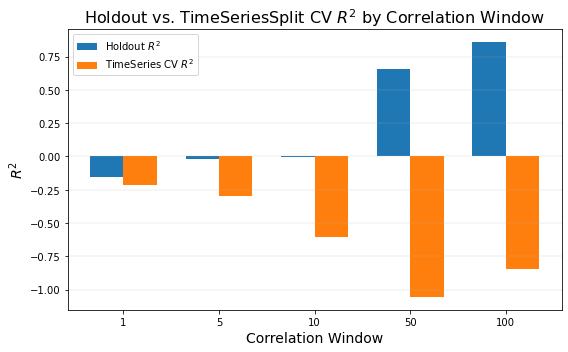

In [ ]:
windows = [1, 5, 10, 50, 100]
num_samples = 1000
num_var = 6

results = []

for w in windows:
    variables = [generate_signal(num_samples, w) for _ in range(num_var)]
    df = pd.DataFrame(
        np.column_stack(variables),
        columns=[f'x{i}' for i in range(1,6)] + ['y']
    )

    data = df.drop(['y'], axis=1)
    target = df['y']

    # 1) Holdout split
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=42, shuffle=True)
    
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    holdout_r2 = r2_score(y_test, y_pred)
    
    # 2) TimeSeriesSplit CV
    tscv = TimeSeriesSplit(n_splits=5)
    ts_r2_scores = []
    for train_idx, test_idx in tscv.split(data):
        regressor.fit(data.iloc[train_idx], target.iloc[train_idx])
        y_ts_pred = regressor.predict(data.iloc[test_idx])
        ts_r2_scores.append(r2_score(target.iloc[test_idx], y_ts_pred))
    ts_cv_r2 = np.mean(ts_r2_scores)
    
    results.append({
        'window': w,
        'holdout_r2': holdout_r2,
        'ts_cv_r2': ts_cv_r2
    })

metrics_df = pd.DataFrame(results)


ind = np.arange(len(windows))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(ind, metrics_df['holdout_r2'], width, label=r'Holdout $R^2$')
plt.bar(ind + width, metrics_df['ts_cv_r2'], width, label=r'TimeSeries CV $R^2$')
plt.xlabel('Correlation Window', fontsize=14)
plt.ylabel(r'$R^2$', fontsize=14)
plt.title(r'Holdout vs. TimeSeriesSplit CV $R^2$ by Correlation Window', fontsize=16)
plt.xticks(ind + width/2, windows)
plt.legend()
plt.grid(axis='y', linewidth=0.3, alpha=0.7)
plt.tight_layout()
plt.show()


## K-Fold

In [ ]:
windows = [1, 5, 10, 50, 100]
num_samples = 1000
num_var = 6

kf = KFold(n_splits=5)

kf_results = []
for w in windows:
    variables = [generate_signal(num_samples, w) for _ in range(num_var)]
    df = pd.DataFrame(
        np.column_stack(variables),
        columns=[f'x{i}' for i in range(1,6)] + ['y']
    )
    
    data = df.drop(['y'], axis=1) # x1,...,x5
    target = df['y']
    
    
    scores = cross_val_score(regressor, data, target, cv=kf, scoring='r2')
    for fold, score in enumerate(scores, start=1):
        kf_results.append({'window': w, 'fold': fold, 'r2': score})

scores_df = pd.DataFrame(kf_results)